In [1]:
import time 
import datetime
import os
from pathlib import Path
import torch
os.environ['HF_HOME'] = '/data/loriss21dm/hfcache'

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [3]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("TODO", max_len=512)

/data/loriss21dm/TracInVenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/loriss21dm/TracInVenv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
checkpoints = [str(x) for x in Path("/data/loriss21dm/babylm/TODO/").glob("checkpoint-*") if (int(str(x).split("-")[-1]) % 10000) == 0]#if (int(str(x).split("-")[-1] % 1000)) == 0]
checkpoints

['/data/loriss21dm/babylm/TODO/checkpoint-20000',
 '/data/loriss21dm/babylm/TODO/checkpoint-90000',
 '/data/loriss21dm/babylm/TODO/checkpoint-10000',
 '/data/loriss21dm/babylm/TODO/checkpoint-50000',
 '/data/loriss21dm/babylm/TODO/checkpoint-80000',
 '/data/loriss21dm/babylm/TODO/checkpoint-40000',
 '/data/loriss21dm/babylm/TODO/checkpoint-60000',
 '/data/loriss21dm/babylm/TODO/checkpoint-70000',
 '/data/loriss21dm/babylm/TODO/checkpoint-30000']

In [5]:
from transformers import RobertaConfig
from transformers import RobertaForMaskedLM


config = RobertaConfig.from_pretrained(checkpoints[0])
model = RobertaForMaskedLM(config=config)
model

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [6]:
from transformers import pipeline


2024-10-03 10:30:02.955022: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 10:30:02.974969: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 10:30:02.993240: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 10:30:02.998639: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 10:30:03.012717: I tensorflow/core/platform/cpu_feature_guar

In [7]:
# [pipeline(
#     "fill-mask",
#     model=checkpoint,
#     tokenizer=tokenizer
# )("The sky is <mask>.")[0]["sequence"]
# for checkpoint in checkpoints]

In [8]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [9]:
from datasets import load_dataset
dataset = load_dataset("text", data_dir="/data/loriss21dm/babylm/train_100M/")
dataset.set_transform(lambda x : tokenizer(x["text"], return_special_tokens_mask=True, truncation=True, max_length=512))

In [10]:
# def torch_mask_tokens(inputs, special_tokens_mask=None):
#     """
#     Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original.
#     """
#     import torch

#     labels = inputs.clone()
#     # We sample a few tokens in each sequence for MLM training (with probability `self.mlm_probability`)
#     probability_matrix = torch.full(labels.shape, self.mlm_probability)
#     if special_tokens_mask is None:
#         special_tokens_mask = [
#             self.tokenizer.get_special_tokens_mask(val, already_has_special_tokens=True) for val in labels.tolist()
#         ]
#         special_tokens_mask = torch.tensor(special_tokens_mask, dtype=torch.bool)
#     else:
#         special_tokens_mask = special_tokens_mask.bool()

#     probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
#     masked_indices = torch.bernoulli(probability_matrix).bool()
#     labels[~masked_indices] = -100  # We only compute loss on masked tokens

#     # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
#     indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
#     inputs[indices_replaced] = self.tokenizer.convert_tokens_to_ids(self.tokenizer.mask_token)

#     # 10% of the time, we replace masked input tokens with random word
#     indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
#     random_words = torch.randint(len(self.tokenizer), labels.shape, dtype=torch.long)
#     inputs[indices_random] = random_words[indices_random]

#     # The rest of the time (10% of the time) we keep the masked input tokens unchanged
#     return inputs, labels

In [11]:
torch.nn.utils.rnn.pad_sequence([torch.tensor(x) for x in dataset["train"][0:10]["input_ids"]], batch_first=True, padding_value=1)

tensor([[    0,   793,   315,   311,   538,   323,    16,   296,   413,    16,
           263,  4492,    16,   492,   263,  1750,  3298,  1379,    16,   329,
           390,   265,  1083,   380,   263,  1750,  3298,   305,   263,   811,
           311,   612,    16,   492,   650,    16,   650,  1049,    11,   612,
            18,     2,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1],
        [    0,  1653,    18,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1

In [12]:
data_collator.torch_mask_tokens(torch.nn.utils.rnn.pad_sequence([torch.tensor(x) for x in dataset["train"][0:10]["input_ids"]], batch_first=True, padding_value=1))

(tensor([[    0,     4,   315,   311,   538,   323,    16,   296,   413,    16,
              4,  4492,    16,   492,   263,  1750,  3298,  1379,    16,   329,
            390,   265, 46062,   380,     4,     4,  3298,   305,   263,   811,
            311,   612,    16,   492,   650,    16,   650,     4,    11,   612,
             18,     2,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1],
         [    0,  1653,     4,     2,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
 

In [13]:
torch.tensor(dataset["train"][0]["input_ids"]).unsqueeze(dim=0)

tensor([[   0,  793,  315,  311,  538,  323,   16,  296,  413,   16,  263, 4492,
           16,  492,  263, 1750, 3298, 1379,   16,  329,  390,  265, 1083,  380,
          263, 1750, 3298,  305,  263,  811,  311,  612,   16,  492,  650,   16,
          650, 1049,   11,  612,   18,    2]])

In [14]:
data_collator((torch.tensor(dataset["train"][0]["input_ids"]),))

{'input_ids': tensor([[   0,    4,  315,  311,  538,  323,   16,  296,  413,   16,  263, 4492,
            16,  492,  263, 1750, 3298,    4,   16,  329,  390,    4, 1083,  380,
           263, 1750, 3298,    4,  263,    4,  311,  612,   16,  492,  650,   16,
           650, 1049,    4,  612, 5076,    2]]),
 'labels': tensor([[-100,  793, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
          -100, -100, -100, -100, -100, 1379, -100, -100, -100,  265, -100, -100,
          -100, -100, -100,  305, -100,  811, -100, -100, -100, -100, -100, -100,
          -100, -100,   11, -100,   18, -100]])}

In [15]:
def get_loss(model, logits, labels):
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss_fct = torch.nn.CrossEntropyLoss()
    shift_logits = shift_logits.view(-1, shift_logits.shape[-1])
    shift_labels = shift_labels.view(-1)
    # Enable model parallelism
    shift_labels = shift_labels.to(shift_logits.device)
    loss = loss_fct(shift_logits, shift_labels)
    
    return loss

In [16]:
# def get_loss(model, logits, labels):
#     print(logits)
#     print(labels)
#     loss_fct = CrossEntropyLoss()
#     masked_lm_loss = loss_fct(prediction_scores.view(-1, self.config.vocab_size), labels.view(-1))

In [17]:
device="cuda"

In [18]:
def get_loss_gradient(model, example):
    model.train()
    model.zero_grad()
    # input_ids, attention_mask = tokenizer([example], return_tensors='pt', return_token_type_ids=False,padding='max_length', truncation=True, max_length=512).values()
    input_ids, labels = data_collator((torch.tensor(dataset["train"][0]["input_ids"]),)).values() # TODO make static maybe probably
    #print("labels",labels)
   # print(input_ids.shape)
    # print(attention_mask)
    inputs_embeds=model.get_input_embeddings().weight[input_ids].to(device)
   # attention_mask = attention_mask
   # print(inputs_embeds.reshape(1,-1,2048).shape)

    inputs_embeds.retain_grad()

    outputs = model.forward(
       #     input_ids=input_ids,
            inputs_embeds=inputs_embeds,
           # attention_mask=attention_mask,
            labels=labels.to(device)
       #     attention_bias=attention_bias,
       #     past_key_values=past_key_values,
       #     use_cache=use_cache,
        #    output_hidden_states=output_hidden_states,
        )
    #print("o", outputs)
    loss = outputs.loss
    loss.retain_grad()
   # print(torch.autograd.grad(loss, inputs_embeds, retain_graph=True)[0].shape)
    return  torch.autograd.grad(loss, inputs_embeds, retain_graph=True)[0].squeeze()



In [19]:
def pw_influence_at_cp(model, test_example, train_examples): 
    return (get_loss_gradient(model, test_example) * torch.stack([get_loss_gradient(model, train_example) for train_example in tqdm(train_examples,desc="Documents", leave=False)])).sum(1).sum(1)

In [20]:
from tqdm import tqdm

In [21]:
len(dataset["train"])

11588684

In [22]:
training_examples = dataset["train"][0:1000]#["test this me", "BERT is BERT","Test document is hello"]


start = time.time()

models = []
gradients_at_checkpoints = []
for checkpoint in tqdm(checkpoints, desc="Checkpoints", total=len(checkpoints),position=1,maxinterval=0.5):
  
  config = RobertaConfig.from_pretrained(checkpoint)
  model = RobertaForMaskedLM(config=config).to(device)
  gradients = []
  for example in tqdm(training_examples["input_ids"], desc="Documents", total=len(training_examples["input_ids"]),position=0,leave=True,maxinterval=0.5):
    gradients.append(get_loss_gradient(model, example))
  gradients_at_checkpoints.append(gradients)
end = time.time()
print(datetime.timedelta(seconds=end - start))    


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Checkpoints: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [04:36<00:00, 30.68s/it]

0:04:36.158187


In [23]:
t =torch.stack([torch.stack(gradients) for gradients in gradients_at_checkpoints]).cpu()
t.shape

torch.Size([9, 1000, 42, 768])

In [24]:
t.sum(0).shape

torch.Size([1000, 42, 768])

In [25]:
import numpy as np

In [26]:
t_flat = t.flatten(-2,-1)
t_flat.shape

torch.Size([9, 1000, 32256])

In [27]:
torch.transpose(t_flat, 1,2).shape

torch.Size([9, 32256, 1000])

In [28]:
torch.bmm(t_flat, torch.transpose(t_flat, 1,2)).shape

torch.Size([9, 1000, 1000])

In [29]:
# np.dot(t_flat, torch.transpose(t_flat, 1,2))

In [30]:
torch.einsum('ijk,lmi->ijm', t_flat, t_flat.T).shape

/tmp/ipykernel_226462/2191972349.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3697.)
  torch.einsum('ijk,lmi->ijm', t_flat, t_flat.T).shape


torch.Size([9, 1000, 1000])

In [190]:
aaa = 
aaa.shape

torch.Size([9, 1000])

In [191]:
aaa[:,0:10].shape

torch.Size([9, 10])

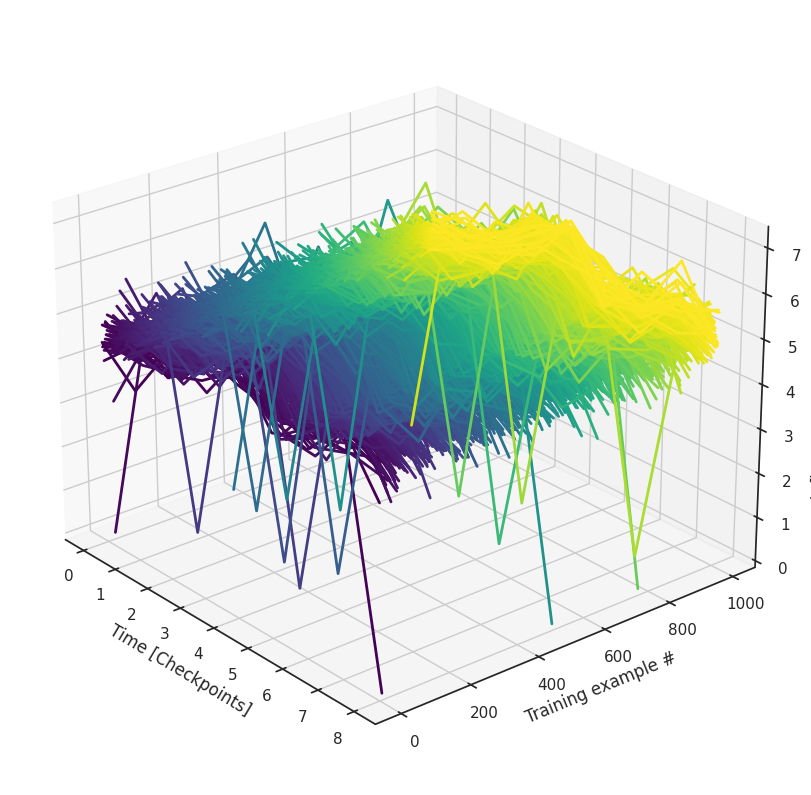

In [222]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
tensor = torch.bmm(t_flat, torch.transpose(t_flat, 1,2)).mean(1)[:, 0:10000]

x = np.arange(tensor.shape[0])  
y = np.arange(tensor.shape[1])


fig = plt.figure(figsize=(10, 15))
ax = fig.add_subplot(111, projection='3d')

colors = cm.viridis(np.linspace(0, 1, tensor.shape[1]))
for i in range(tensor.shape[1]):  
    ax.plot(x, np.full_like(x, y[i]), tensor[:, i], color=colors[i], linewidth=2)


ax.set_xlabel('Time [Checkpoints]')
ax.set_ylabel('Training example #')
ax.set_zlabel('Influence at checkpoint')


ax.view_init(elev=25, azim=-40, roll=0)

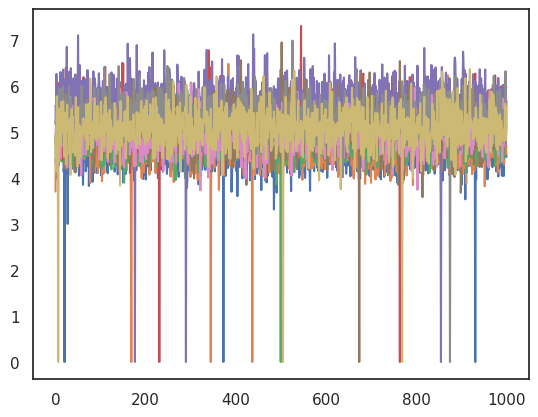

In [194]:
plt.plot(aaa.T)

In [132]:
aaa.shape

torch.Size([9, 1000])

In [134]:
plt.bar.plot(aaa)

AttributeError: 'function' object has no attribute 'plot'

In [120]:
torch.bmm(t_flat, torch.transpose(t_flat, 1,2).shape

torch.Size([9000])

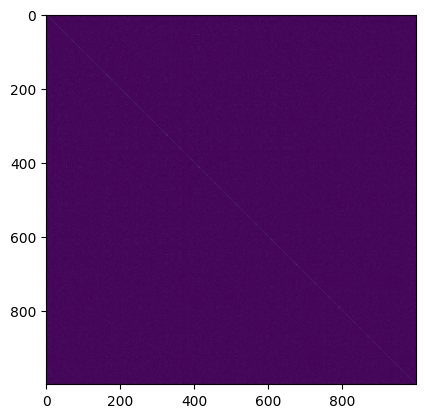

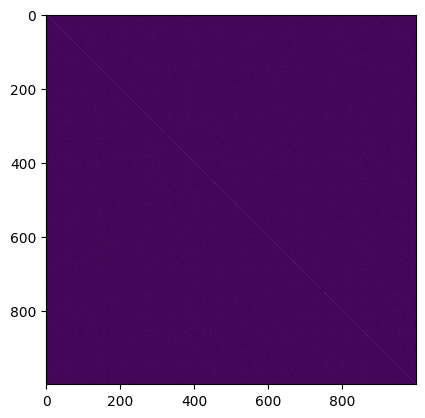

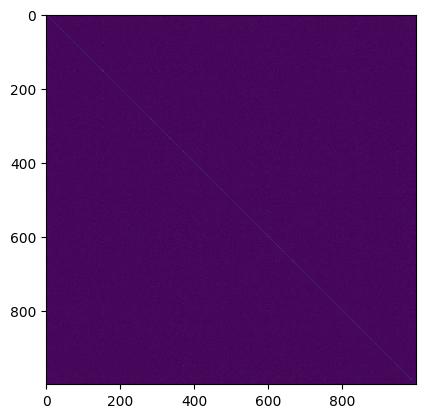

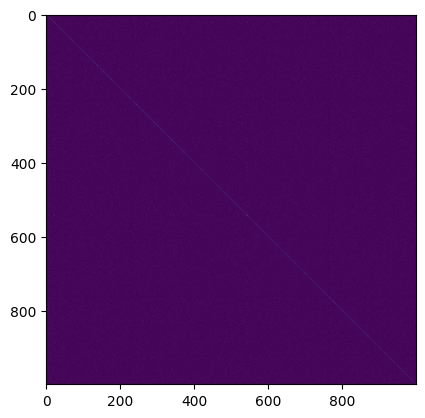

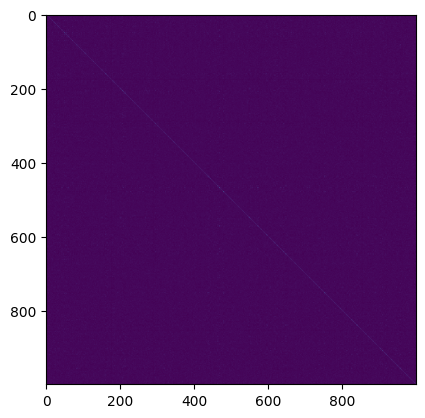

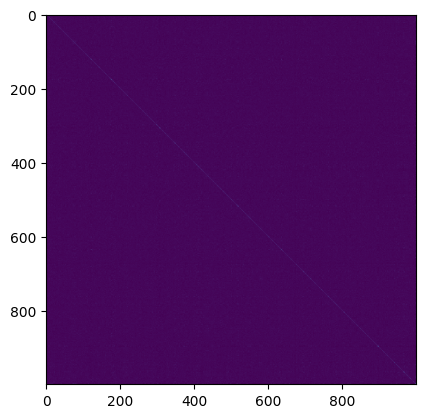

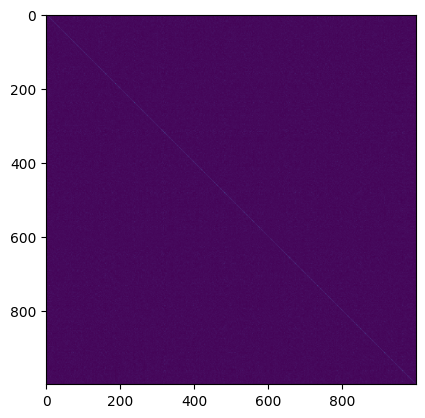

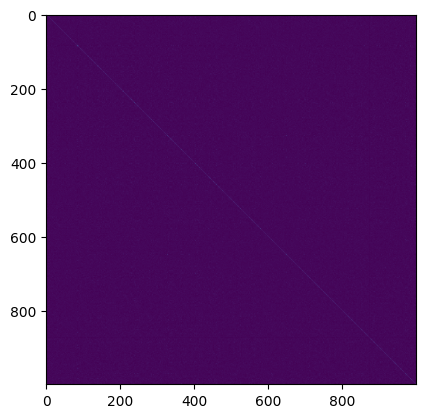

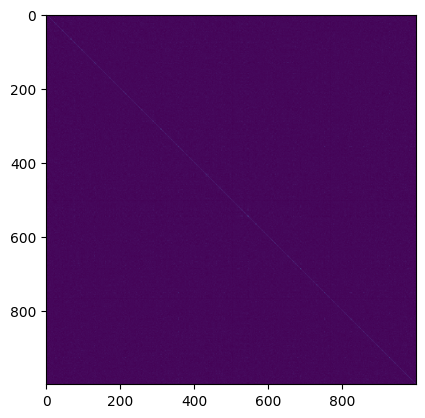

In [31]:

for i, inf in enumerate(torch.bmm(t_flat, torch.transpose(t_flat, 1,2))):
    plt.imshow(inf)
    plt.show()

In [32]:
np.einsum('ijkl,nolp->ijnokp', t_flat, t_flat.T)

ValueError: einstein sum subscripts string contains too many subscripts for operand 0

In [24]:
# # test_instance =  "Test <mask>"
# # training_examples = ["test", "is"]


# start = time.time()

# models = []
# influences_at_cps = []
# for checkpoint in tqdm(checkpoints, desc="Checkpoints"):
#   config = RobertaConfig.from_pretrained(checkpoint)
#   model = RobertaForMaskedLM(config=config)
#   influences_at_cps.append(pw_influence_at_cp(model, test_instance,training_examples["input_ids"]))
# end = time.time()
# print(datetime.timedelta(seconds=end - start))    
# influences_total = torch.stack(influences_at_cps).sum(dim=0)
# influences_total

In [25]:
torch.stack(influences_at_cps).T.shape

NameError: name 'influences_at_cps' is not defined

In [83]:
influences_total

tensor([111.0442, 137.1939])